# The current notebook contains code for the prediction of house pricing, based on 79 explanatory variables of different characteristics/conditions of residential homes. 

This is the House Pricing Kaggle challenge. For more details about this challenge visit: [House Pricing Kaggle Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) 

The prediction is perfomed using a Random Forest Regressor


---
## Importing libraries and modules

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
# so that we do not receive warnings every time
# we overwrite dataframes 
import time
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestRegressor as rfrg 
from sklearn.decomposition import PCA  
from sklearn.feature_selection import mutual_info_classif as MI 
from sklearn.metrics import mean_squared_error as MSE 
from itertools import compress 

## Upload the data

In [2]:
import os
path = os.getcwd()
path=path+'/DATA'
df_train = pd.read_csv(path+'/train.csv')
df_test = pd.read_csv(path+'/test.csv')

print("Rows in training database: {}".format(df_train.shape[0]))
print("\nRows in test database: {}".format(df_test.shape[0]))

Rows in training database: 1460

Rows in test database: 1459


## Dealing with Null values

In [3]:
null_in_train = df_train.isnull().sum(axis=0) > 0
null_in_test = df_test.isnull().sum(axis=0) > 0

In [4]:
print("Columns in train database with null entries: {}".format(null_in_train.sum()))

Columns in train database with null entries: 19


In [5]:
print("Columns in test database with null entries: {}".format(null_in_test.sum()))

Columns in test database with null entries: 33


In [6]:
null_cols_train = null_in_train.index[null_in_train]
null_cols_test = null_in_test.index[null_in_test]

In [7]:
df_train[null_cols_train]

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,None,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,None,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,NaN,None,0.0,Gd,TA,No,Unf,Unf,SBrkr,TA,Attchd,1999.0,RFn,TA,TA,NaN,NaN,NaN
1456,85.0,NaN,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,TA,Attchd,1978.0,Unf,TA,TA,NaN,MnPrv,NaN
1457,66.0,NaN,None,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Gd,Attchd,1941.0,RFn,TA,TA,NaN,GdPrv,Shed
1458,68.0,NaN,None,0.0,TA,TA,Mn,GLQ,Rec,FuseA,NaN,Attchd,1950.0,Unf,TA,TA,NaN,NaN,NaN


In [8]:
df_test[null_cols_test]

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RH,80.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,TA,TA,...,1961.0,Unf,1.0,730.0,TA,TA,NaN,MnPrv,NaN,WD
1,RL,81.0,NaN,AllPub,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,...,1958.0,Unf,1.0,312.0,TA,TA,NaN,NaN,Gar2,WD
2,RL,74.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,Gd,TA,...,1997.0,Fin,2.0,482.0,TA,TA,NaN,MnPrv,NaN,WD
3,RL,78.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,20.0,TA,TA,...,1998.0,Fin,2.0,470.0,TA,TA,NaN,NaN,NaN,WD
4,RL,43.0,NaN,AllPub,HdBoard,HdBoard,None,0.0,Gd,TA,...,1992.0,RFn,2.0,506.0,TA,TA,NaN,NaN,NaN,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,21.0,NaN,AllPub,CemntBd,CmentBd,None,0.0,TA,TA,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,WD
1455,RM,21.0,NaN,AllPub,CemntBd,CmentBd,None,0.0,TA,TA,...,1970.0,Unf,1.0,286.0,TA,TA,NaN,NaN,NaN,WD
1456,RL,160.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,TA,TA,...,1960.0,Unf,2.0,576.0,TA,TA,NaN,NaN,NaN,WD
1457,RL,62.0,NaN,AllPub,HdBoard,Wd Shng,None,0.0,Gd,TA,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,MnPrv,Shed,WD


In [9]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Function for replacing NaN values depending on its fraction with respect to not null values in the corresponding column

In [10]:
def replace_nan(df,null_cols,
                min_frac_notnan = 0.1):
    """
    Args: 
        df : pd.dataframe
        null_cols : index. Names of the columns
                           containing null values
        min_frac_notnan : float. Minimum fraction of 
                                not null values to consider 
                                the corresponding column
                                Default : 0.1
    """
    discarded_cols = []
    for col in null_cols:
        frac_notnan = 1 - df[col].isnull().sum()/df.shape[0]
        if frac_notnan < min_frac_notnan:
            discarded_cols.append(col)
        
    cols_to_check = list(set(list(null_cols)) - set(discarded_cols))
    for col in cols_to_check:
        not_null = df[col].notnull() 
        data_type = df[col][not_null].dtype
        if data_type == 'object': 
            df[col][df[col].isnull()] = df[col].value_counts().idxmax()
        else:
            df[col][df[col].isnull()] = df[col][not_null].mean()
    
    return df, discarded_cols        

### Replacing NaN values in training database

In [11]:
df_train, discarded_cols_train = replace_nan(df_train,null_cols_train)

In [12]:
discarded_cols_train

['Alley', 'PoolQC', 'MiscFeature']

### Replacing NaN values in test database

In [13]:
df_test, discarded_cols_test = replace_nan(df_test,null_cols_test)

In [14]:
discarded_cols_test

['Alley', 'PoolQC', 'MiscFeature']

### Discard columns with 'too many' NaN values 

In [15]:
df_train = df_train.drop(columns=discarded_cols_train)
df_test = df_test.drop(columns=discarded_cols_test)

### Check that the databases have no NaN values anymore

In [16]:
(df_train.isnull().sum(axis=0) > 0).max()

False

In [17]:
(df_test.isnull().sum(axis=0) > 0).max()

False

---
## Convert the string columns into numerical values

In [18]:
string_cols = df_train.select_dtypes('object').columns
string_cols_test = df_test.select_dtypes('object').columns
if np.min(string_cols == string_cols_test):
    print('String columns coincide in both training and test databases')
else:
    print('String columns in training database DO NOT coincide with those in test database')

String columns coincide in both training and test databases


### Extract bag-of-characters from the string columns in training database 

In [19]:
## List of words from each string column 
lists_of_words = []
for col in string_cols:
    lists_of_words.append(df_train[col].unique())
## Split each word into its characters
bag_of_charac = []
max_word_length = []
for word_list in lists_of_words:
    ## Max word length for each column
    max_word_length.append(np.max([len(w) for w in word_list]))
    ## Gather all the characters for a given column 
    characters = [c for w in word_list for c in w]
    boc = {}
    ## Fill in the bag-of-characters 
    for c in characters:
        if c not in boc:
            boc[c]=len(boc)
    bag_of_charac.append(boc)
## Check that no string column in test database has new elements with respect the corresponding column 
## in the training database
is_test_in_train = []    
for i in range(len(string_cols)):
    col = string_cols[i]
    isit_in = True
    for w in df_test[col].unique():
        isit_in = min(isit_in, w in lists_of_words[i])
    is_test_in_train.append(isit_in)

if min(is_test_in_train):
    print('No string column in test database contains elements\nnot found in the corresponding column in training')
else:
    print('Some string columns in test database contain new elements')

No string column in test database contains elements
not found in the corresponding column in training


### Convert the strings into numbers

In [20]:
bag_of_words = []
for i in range(len(lists_of_words)):
    L = lists_of_words[i]
    length = max_word_length[i]
    boc = bag_of_charac[i]
    bow = {}
    for word in set(L):
        value = np.array([boc[c] for c in word]) @ len(boc)**np.arange(len(word))
        bow[word] = value
    bag_of_words.append(bow)

for i in range(len(string_cols)):
    col = string_cols[i]
    bow = bag_of_words[i]
    for w,value in bow.items():
        df_train[col][df_train[col] == w] = value
        df_test[col][df_test[col] == w] = value

---
## Computing mutual information between 'SalePrice' and the rest of columns

In [21]:
cols_to_check = list(set(list(df_train.columns))-set(['Id','SalePrice']))
mutual_info = np.zeros(len(cols_to_check))

tic = time.perf_counter()
for i in range(len(cols_to_check)):
    col = cols_to_check[i]
    mutual_info[i] = MI((df_train[col]).to_numpy().reshape(-1,1),df_train['SalePrice'].to_numpy())
toc = time.perf_counter()

print("Computation time: {:.2f} seconds".format(toc-tic))

Computation time: 8.31 seconds


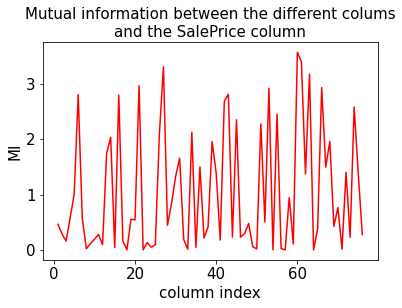

In [22]:
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.plot(np.arange(1,len(cols_to_check)+1) , mutual_info,'r-',linewidth = 1.5)
plt.xlabel('column index',fontsize = 15)
plt.ylabel('MI',fontsize = 15)
plt.title('Mutual information between the different colums\nand the SalePrice column', fontsize = 15)
plt.show()

### Discard columns sharing very little information with SalePrice
Discard those columns for which $MI \leq 0.1$  

In [23]:
selected_cols = list(compress(cols_to_check , mutual_info > 0.1))

---
## Extracting feature vectors from training and test databases

### x_train

In [24]:
x_train = df_train[selected_cols].to_numpy().astype(float)

### y_train

In [25]:
y_train = df_train['SalePrice'].to_numpy().astype(float)

### x_test

In [26]:
x_test = df_test[selected_cols].to_numpy().astype(float)

## Normalize the data

In [27]:
x_train = x_train / x_train.max(axis=0)
x_test = x_test / x_test.max(axis=0)

---
## PCA analysis

In [28]:
pca = PCA(n_components=10)
# Centering the training data
x_cent = (x_train.T-x_train.mean(axis=1)).T
pca.fit(x_cent)
# Extract the PC of the centered data
pcx_train = pca.transform(x_cent)

# Centering the test data
x_cent = (x_test.T-x_test.mean(axis=1)).T
pca.fit(x_cent)
# Extract the PC of the centered data
pcx_test = pca.transform(x_cent)

### PCA plotting function

In [29]:
def pc_plot(data,n_pc_comp=2):
    """
    Generates the scatter plot of the PCA transformed data
    Args:
        data : numpy array of shape (n_samples,dim_feature)
               Containd the PC decomposition of the (centered)
               original data
        n_pc_comp : integer. 
                    Number of principal components to plot
                    Default n_pc_comp = 2
    """
    
    if n_pc_comp not in [2,3]:
        n_pc_comp = 2
    
    title = 'Principal components of training feature vectors'
    
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    mean_price = df_train['SalePrice'].mean()
    color_red = df_train['SalePrice'] > mean_price # high saling price
    color_blue = np.logical_not(color_red) # low saling price 
    
    MS = 30 # Marker Size
    
    if n_pc_comp == 2:
        
        ## Plot data with label: no extra baggage

        plt.scatter(data[color_blue,0],data[color_blue,1],
                  s=MS,c = 'b',marker = '.')

        ## Plot data with label: extra baggage
        plt.scatter(data[color_red,0],data[color_red,1],
                  s=MS,c = 'r',marker = '.')

        plt.legend(['low price','high price'])

        plt.xlabel('pc1', fontsize=20)
        plt.ylabel('pc2', fontsize=20)
        plt.title(title,fontsize=20)
        plt.show()
    else:
        figsize = (30,30)
        fig = plt.figure()
        ax = Axes3D(fig)

        ## Plot data with label: no extra baggage
        ax.scatter(data[color_blue,0],data[color_blue,1],data[color_blue,2],
                   c = 'b',marker = '.')

        ## Plot data with label: extra baggage
        plt.scatter(data[color_red,0],data[color_red,1],data[color_red,2],
                    c = 'r',marker = '.')

        ax.legend(['low price','high price'])

        ax.set_xlabel('pc1', fontsize=20)
        ax.set_ylabel('pc2', fontsize=20)
        ax.set_zlabel('pc3', fontsize=20)
        ax.set_title(title,fontsize=20)
        plt.show()



### Plotting the first 2 principal components

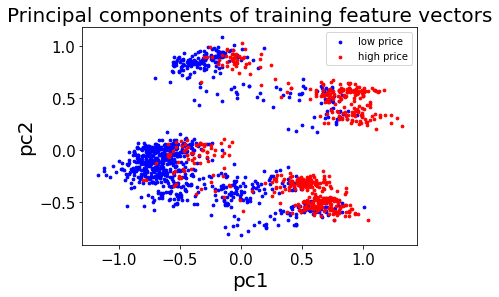

In [30]:
pc_plot(pcx_train)

### Plotting the first 3 pricipal components

/Users/daviddiegocastro/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


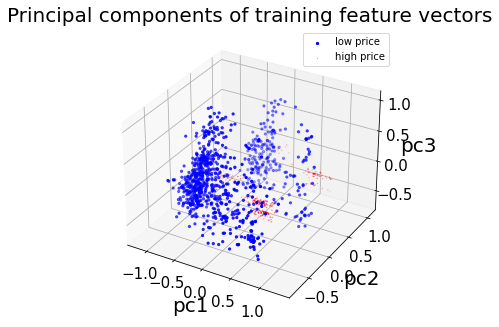

In [31]:
pc_plot(pcx_train, n_pc_comp = 3)

---
# Fitting the model using a Random Forest Regression

## Setting the method
The options for the method are: 
* method = 'feat'
    * The fitting is preformed on the whole feature vector
* method = 'pca'
    * The fitting is preformed on the PCA reduction
    * n_pc : Number of principal components to use in the fit

## Performance metric
The Root Mean Squared Error corresponding to the logarithm of the values, that is:

$$RMSE_{log}(y,\hat y) = \sqrt{\frac{1}{n} \sum_{i=0}^{n-1} (\ln(y_i)-\ln(\hat y_i))^2}$$

Numerically, we will consider $\ln(max(|y_i|,\epsilon))-\ln(max(|\hat y_i|,\epsilon))$ for $\epsilon > 0$ but very small, to avoid taking the logarithm of negative values or very small values.

In [32]:
def rmse_log(y,y_pred,
            eps=10**(-8)):
    """
    Args:
       y : numpy array of size (n,)
       y_pred : numpy array of size (n,)
       eps : float. Small parameter to deal with 
             possible vaniching values
             Dafault : 1e**(-8)
       
    Returns:
       RMSE_log
    """
    
    y_abs = np.abs(y)
    y_pred_abs = np.abs(y_pred)
    y_abs[y_abs < eps] = eps
    y_pred_abs[y_pred_abs < eps] = eps
    
    return MSE(np.log(y_abs),np.log(y_pred_abs),squared = False)
    

## Extracting the training sample
This function extracts a random sample from the training data of size sample_size.
In addition: 

    * If method = 'feat', the sample consists of full feature vectors.
    * If method = 'pca', the sample consists of the first n_pc components from the PCA reduction.  



In [33]:
def extract_sample(sample_size, method = 'feat', n_pc = 3):
    """
    Extracts a sample from the training data
    
    Args:
        sample_size : integer. The size of the sample
        method : string. If method = 'feat' : extracts sample from x_train
                         If method = 'pca' : extracts sample from the pcx_train
                         Default : method = 'feat'
        n_pc : integer. Number of principal components to use
                        when method = 'pca'
                        Default : npc = 3
                         
    Returns:
        tuple : (sample , y_sample)
                sample : 2d numpy array containing the training sample
                y_sample : 1d numpy array containing the corresponding labels
                 
    """
    ## Get a copy of the suitable data according the method
    if method == 'feat':
        sample = x_train.copy()
    else:
        sample = pcx_train[:,:n_pc].copy()
    
    y_sample = y_train.copy()
    
    ## Get a permutation of the training feature vector indices
    perm = np.arange(x_train.shape[0])
    np.random.shuffle(perm)
    
    ## Sample the data
    sample = sample[perm]
    y_sample = y_sample[perm]

    sample = sample[:sample_size]
    y_sample = y_sample[:sample_size]
    
    return sample, y_sample 

## Function to optimize the PC reduction

In [34]:
def pca_opt(sample_size):
    ## Principal components
    n_pcs = np.arange(2,pcx_train.shape[1]+1)
    rmse = []
    
    tic = time.perf_counter()
    for n in n_pcs:
        sample, y_sample = extract_sample(sample_size,
                                         method = 'pca', n_pc = n)
        
        regress = rfrg(random_state=0)
        regress.fit(sample,y_sample)
        pred = regress.predict(sample)
        rmse.append(rmse_log(y_sample,pred))
    
    best_n_pc = n_pcs[np.argmin(rmse)]
    
    title = 'RMSE-log vs number of pc'
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    plt.plot(n_pcs,rmse,'r-',linewidth = 1.5)
    plt.xlabel('number of pc',fontsize = 15)
    plt.ylabel('RMSE-log',fontsize = 15)
    plt.title(title,fontsize = 15)
    plt.show()
    toc = time.perf_counter()
    
    print("Computation time: {:.2f} seconds\n".format(toc-tic))
    print("Best performing number of pc: {}".format(best_n_pc))
    return best_n_pc

## Function to fit the model using a Random Forest Regression

In [35]:
def fit_data(sample_size, method = 'feat',
             n_pc = 3):
    """
    Fits the data using the NuSVC classifier, using
    RBF as kernel
    
    Args:
        sample_size : integer. Size of the training sample 
        method : string. method for extracting the training sample
        n_pc : integer. Number of principal components to use
                        when method = 'pca'
    Returns:
        regress :         the fitted regressor
        predictions : numpy array of shape (n_bookings ,)
                      Contains the extra baggage predictions
                      for the test data
    """
    
    ## Extract the sample
    sample, y_sample = extract_sample(sample_size,
                                    method = method, n_pc = n_pc)
    
    ## Do the fitting

    tic = time.perf_counter()

    regress = rfrg(random_state=0)
    regress.fit(sample,y_sample)

    ## Obtain predictions for the test data

    if method == 'feat':
        predictions = regress.predict(x_test)
    else:
        predictions = regress.predict(pcx_test[:,:n_pc])
    
    ## Compute the Mean Absolute Percentage Error for the training sample 

    pred = regress.predict(sample)
    rmse = rmse_log(y_sample,pred)
    toc = time.perf_counter()

    print("Computation time: {:.2f} seconds\n".format(toc-tic))  
    print("The Root-Mean-Squared-Error-log for the training sample is {:.3f}".format(rmse))
    
    
    return regress, predictions  

---
## Optimize the number of principal components

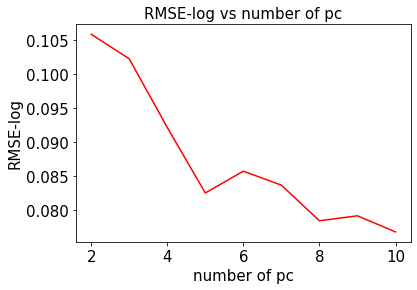

Computation time: 3.81 seconds

Best performing number of pc: 10


In [36]:
n_pc = pca_opt(int(0.8*pcx_train.shape[0]))

## Fit the model on the whole feature vectors

In [37]:
model_feat, predictions_feat = fit_data(int(0.8*x_train.shape[0]))

Computation time: 1.04 seconds

The Root-Mean-Squared-Error-log for the training sample is 0.062


### Validate the fitting
On the whole training set (whose size is comparable to that of the test set)

In [38]:
## Extract the sample
sample, y_sample = extract_sample(int(x_train.shape[0]))
y_val = model_feat.predict(sample)
print("FEAT. RMSE-log for the validation sample: {:.3f}".format(rmse_log(y_sample,y_val)))

FEAT. RMSE-log for the validation sample: 0.091


## Fit the model using the PCA reduction

In [39]:
model_pca, predictions_pca = fit_data(int(0.8*x_train.shape[0]),
                                     method = 'pca', n_pc = n_pc)

Computation time: 0.62 seconds

The Root-Mean-Squared-Error-log for the training sample is 0.078


### Valdate the fitting
On the whole training set (whose size is comparable to that of the test set)

In [41]:
sample, y_sample = extract_sample(int(x_train.shape[0]),
                                 method = 'pca', n_pc = n_pc)
y_val = model_pca.predict(sample)
print("PCA. RMSE-log for the validation sample: {:.3f}".format(rmse_log(y_sample,y_val)))

PCA. RMSE-log for the validation sample: 0.113


---
## Generate the CSV file with the sale price predictions 
(Using the whole feature vector)

In [43]:
SalePrice_Predictions = pd.DataFrame(df_test['Id'])
SalePrice_Predictions['SalePrice'] = predictions_feat
SalePrice_Predictions.to_csv(path_or_buf='SalePricePredictions.csv',index=False)